Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


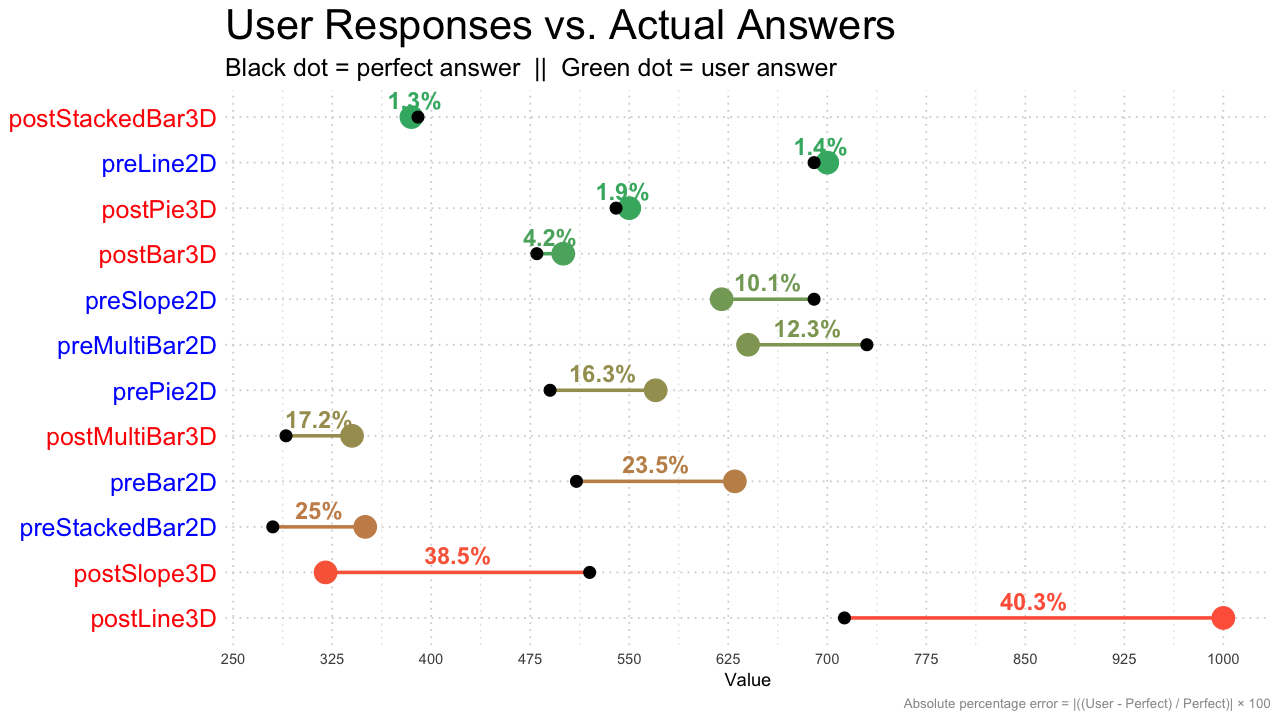

In [3]:
library(tidyverse)
plot.scale <- 1.5
options(
    jupyter.rich_display = FALSE,
    repr.plot.width = 16/plot.scale,
    repr.plot.height = 9/plot.scale)
ggplot2::theme_set(theme_minimal())
process_sessions <- function(csv_path) {
  cosss <- read.csv(csv_path, stringsAsFactors = FALSE)
  # 1) usuń zbędne kolumny
  df_flat <- cosss %>%
    select(
      -c(2:11),
      -Pre, -X
    ) %>%
    group_by(Rec_Session_Id) %>%
    summarise(across(
      .cols = everything(),
      .fns = ~ {
        v <- .x[!is.na(.x)]
        if (length(v)) v[1] else NA
      }
    ), .groups = "drop"
    ) %>%
    select(where(~ !any(is.na(.))))
  return(df_flat)
}

df <- process_sessions("trials.csv")
ans = read.csv("ans.csv", header = T)

df_long <- df %>%
  pivot_longer(
    cols = -Rec_Session_Id,
    names_to = "PlotType",
    values_to = "UserValue"
  )

ans_long <- ans %>%
  pivot_longer(
    cols = everything(), # ans has no Rec_Session_Id
    names_to = "PlotType",
    values_to = "PerfectValue"
  )

# 2. Join them by PlotType
combined <- df_long %>%
  select(-Rec_Session_Id) %>% # drop it, we only need the values
  left_join(ans_long, by = "PlotType")

# 3. Calculate percentage error and order by error
combined <- combined %>%
  mutate(
    # Calculate absolute percentage error
    AbsPercentageError = abs(((UserValue - PerfectValue) / PerfectValue) * 100)
  ) %>%
  # Order PlotType by absolute percentage error (descending - highest error at bottom)
  arrange(desc(AbsPercentageError)) %>%
  mutate(PlotType = factor(PlotType, levels = unique(PlotType)))

# Create the plot with color-coded error
ggplot(combined, aes(y = PlotType)) +
  # Color-coded line between user and perfect values (red = high error, green = low error)
  geom_segment(aes(x = UserValue, xend = PerfectValue,
                   y = PlotType, yend = PlotType,
                   color = AbsPercentageError),
               linewidth = 1) +
  # blue point for user answer
  geom_point(aes(x = UserValue, color = AbsPercentageError),
             size = 6) +
  # orange point for perfect answer
  geom_point(aes(x = PerfectValue),
             size = 3, color = "black") +
  # Add absolute percentage error annotations with color coding
  geom_text(aes(x = (UserValue + PerfectValue) / 2,
                label = paste0(round(AbsPercentageError, 1), "%"),
                color = AbsPercentageError),
            vjust = -0.5, size = 5, fontface = "bold") +
  # Color scale: green for low error, red for high error
  scale_color_gradient(low = "mediumseagreen", high = "tomato",
                       name = "Absolute\nError %") +
  # Custom X-axis ticks every 150 from 250 to 1000
  scale_x_continuous(breaks = seq(250, 1000, 75)) +
  labs(
    x = "Value",
    y = NULL,
    title = "User Responses vs. Actual Answers",
    subtitle = "Black dot = perfect answer  ||  Green dot = user answer",
    caption = "Absolute percentage error = |((User - Perfect) / Perfect)| × 100"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size=25),
    plot.subtitle = element_text(size=15),
    panel.grid = element_line(linetype = "dotted", color="lightgray", linewidth = .5),
    # Color Y-axis text based on 2D/3D ending
    axis.text.y = element_text(
      size = 15,
      color = ifelse(grepl("2D$", levels(combined$PlotType)), "blue", 
                     ifelse(grepl("3D$", levels(combined$PlotType)), "red", "black"))
    ),
    plot.caption = element_text(size = 8, color = "grey60"),
    legend.position = "none", # Remove legend
    
  )